All imports

In [1]:
import os
import sys
import nltk
import random
import whisper
import warnings
import subprocess
import numpy as np
import pandas as pd
from openai import OpenAI
from datetime import timedelta
from dotenv import load_dotenv
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
from moviepy.editor import VideoFileClip
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import make_interp_spline
from nltk.sentiment import SentimentIntensityAnalyzer

In [2]:
load_dotenv()
TWITCH_NICK = os.getenv("TWITCH_NICK")  # Twitch username
TWITCH_TOKEN = os.getenv("TWITCH_TOKEN")  # OAuth token from Twitch
TWITCH_CHANNEL = os.getenv("TWITCH_CHANNEL")  # Channel to join (e.g., "marvelrivals")
DEEPSEEK_API_KEY = os.getenv("DEEPSEEK_API_KEY")
HIGHLIGHTS_DIR = "highlights"
VIDEO_OUTPUT_FILE = f"{TWITCH_CHANNEL}_recorded_stream.mp4"
CHAT_LOG_FILE = f"{TWITCH_CHANNEL}_chat_log.csv"
DESC_SAVE_FILE = 'descriptions.csv'
BLURRED_BACKGROUND_VID = 'Presets'+r'/blurred_minecraft_gameplay.mp4'

nltk.download('vader_lexicon', download_dir='/Users/sunilpc/nltk_data')
sia = SentimentIntensityAnalyzer()

client = OpenAI(api_key=DEEPSEEK_API_KEY, base_url="https://api.deepseek.com")
warnings.filterwarnings("ignore", category=FutureWarning)

transcriber = whisper.load_model("base")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sunilpc/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


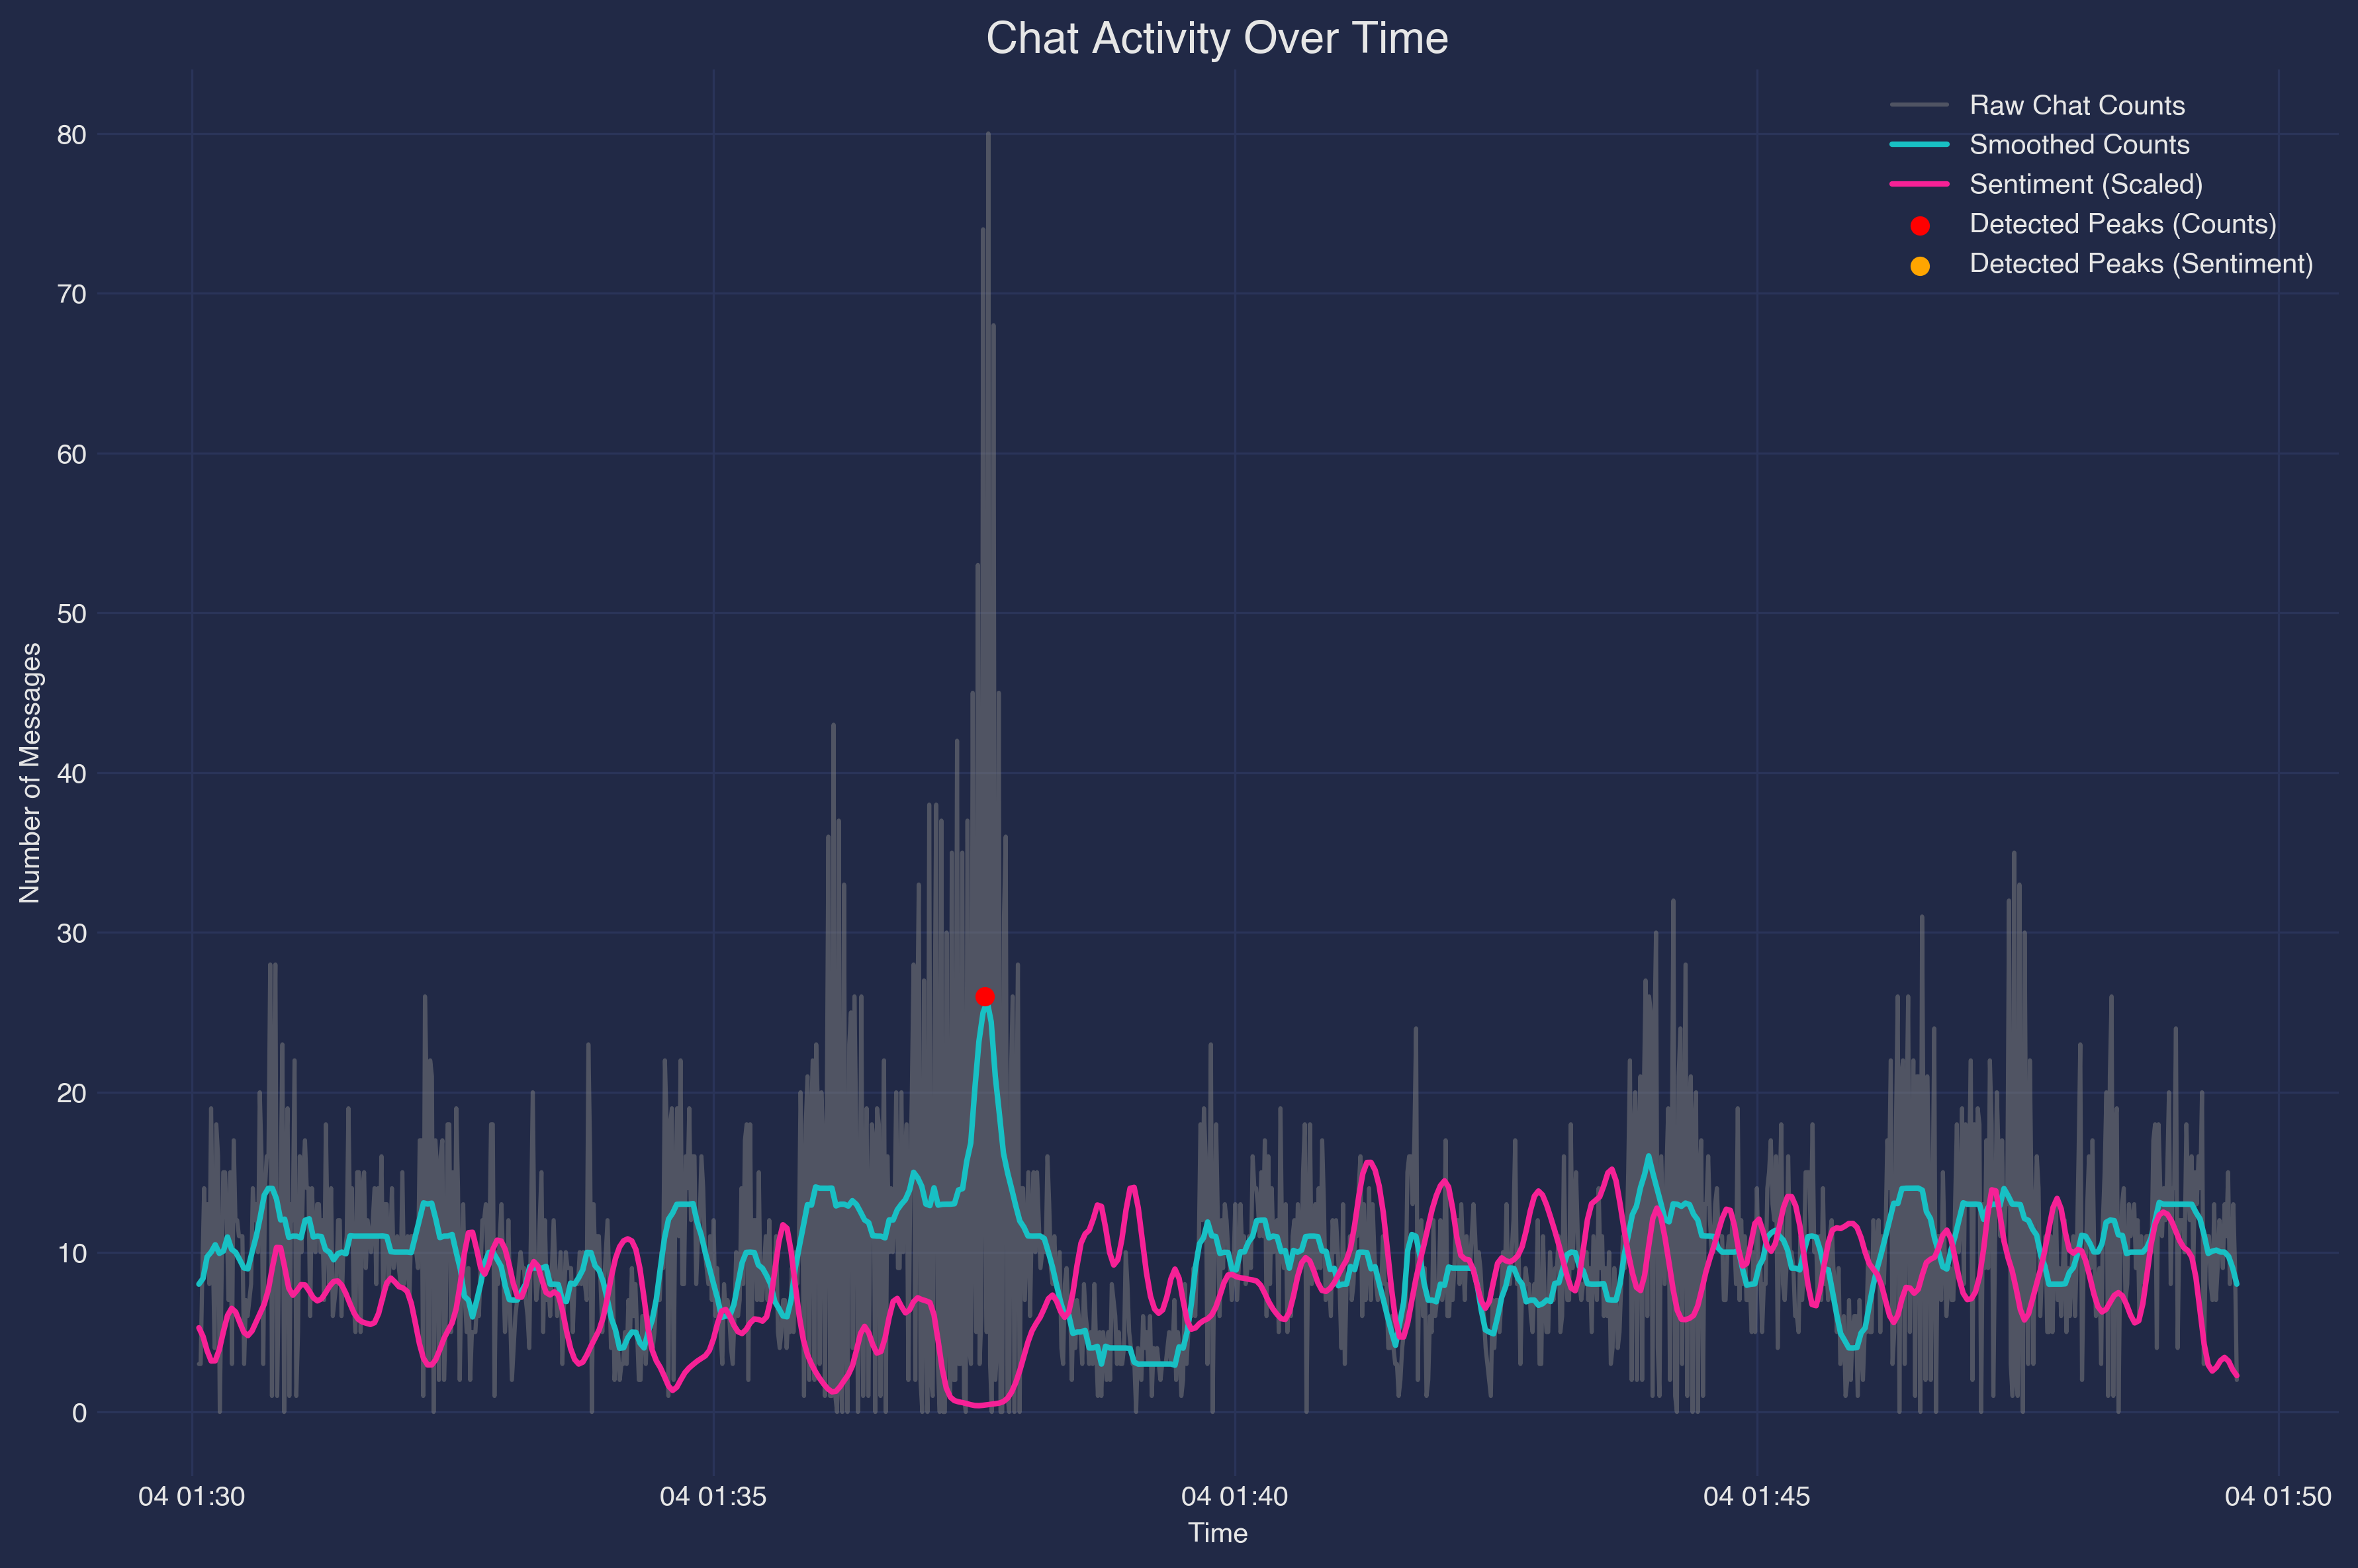

In [3]:
# Analysis Constants
FREQUENCY_RESAMPLE_RATE = "1s"
SENTIMENT_RESAMPLE_RATE = "1s"
FREQUENCY_GAUSSIAN_SIGMA = 4
SENTIMENT_GAUSSIAN_SIGMA = 4
FREQUENCY_STD_COEF = 1
SENTIMENT_STD_COEF = 2

# Read in the Chat Data and Clean
chat_data = pd.read_csv(CHAT_LOG_FILE, parse_dates=["timestamp"])
chat_data["timestamp"] = pd.to_datetime(chat_data["timestamp"])
VIDEO_START_TIME = pd.to_datetime(chat_data['timestamp']).loc[0]-timedelta(seconds=(chat_data['time_in_vid'].loc[0]))
chat_data = chat_data[(chat_data['message'].str.contains(f'#{TWITCH_CHANNEL} :').fillna(False))]
chat_data = chat_data[~(chat_data['message'].str.contains("kushs5497").fillna(True))]
chat_data['username'] = chat_data['message'].apply(lambda x: x.split(':')[1].split('!')[0])
chat_data['entire_contents'] = chat_data['message']
chat_data['message'] = chat_data['entire_contents'].apply(lambda x: x.split(f'#{TWITCH_CHANNEL} :')[1])


# Compute Frequency Peaks
chat_data["count"] = 1
chat_counts = chat_data.resample(FREQUENCY_RESAMPLE_RATE, on="timestamp").sum()["count"].fillna(0)
smoothed_counts = gaussian_filter1d(chat_counts.values, sigma=FREQUENCY_GAUSSIAN_SIGMA)
threshold_counts = chat_counts.mean() + FREQUENCY_STD_COEF * chat_counts.std()
peaks_counts, _ = find_peaks(smoothed_counts, height=threshold_counts, distance=30)
peak_times_freq = chat_counts.index[peaks_counts]

# Compute Sentiment Series
chat_data["sentiment"] = chat_data["message"].apply(lambda x: sia.polarity_scores(x)["compound"]).abs()
chat_sentiment = chat_data.resample(SENTIMENT_RESAMPLE_RATE, on="timestamp").mean(numeric_only=True)["sentiment"].fillna(0)
smoothed_sentiment = gaussian_filter1d(chat_sentiment.values, sigma=SENTIMENT_GAUSSIAN_SIGMA)
threshold_sent = chat_sentiment.mean() + SENTIMENT_STD_COEF * chat_sentiment.std()
peaks_sent, _ = find_peaks(smoothed_sentiment, height=threshold_sent, distance=30)
peak_times_sent = chat_sentiment.index[peaks_sent]

# Interpolate for smoother lines
time_counts = chat_counts.index.astype('int64') // 1e9  # Convert to seconds for interpolation
time_sentiment = chat_sentiment.index.astype('int64') // 1e9  # Convert to seconds for interpolation
smooth_time_counts = np.linspace(time_counts.min(), time_counts.max(), 500)
smooth_time_sentiment = np.linspace(time_sentiment.min(), time_sentiment.max(), 500)
smooth_counts = make_interp_spline(time_counts, smoothed_counts)(smooth_time_counts)
smooth_sentiment = make_interp_spline(time_sentiment, smoothed_sentiment)(smooth_time_sentiment)

# Plot Peaks
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
plt.figure(figsize=(12, 8), dpi=300)

plt.plot(chat_counts.index, chat_counts.values, label="Raw Chat Counts", alpha=0.5, color='gray')

plt.plot(pd.to_datetime(smooth_time_counts, unit='s'), smooth_counts, label="Smoothed Counts", linewidth=2)
plt.plot(pd.to_datetime(smooth_time_sentiment, unit='s'), smooth_sentiment * chat_counts.max(), label="Sentiment (Scaled)", linewidth=2)

plt.scatter(chat_counts.index[peaks_counts], smoothed_counts[peaks_counts], label="Detected Peaks (Counts)", color='red', zorder=3)
plt.scatter(chat_sentiment.index[peaks_sent], smoothed_sentiment[peaks_sent] * chat_counts.max(), label="Detected Peaks (Sentiment)", color='orange', zorder=3)

plt.title("Chat Activity Over Time", fontsize=16)
plt.xlabel("Time")
plt.ylabel("Number of Messages")
plt.legend()
plt.tight_layout()

plt.show()


In [6]:
def generate_title_and_description(min_time,max_time,transcript=None):
    min_time = VIDEO_START_TIME + timedelta(seconds=min_time)
    max_time = VIDEO_START_TIME + timedelta(seconds=max_time)
    message_series = chat_data[(chat_data['timestamp']>min_time) & (chat_data['timestamp']<max_time)]['message']
    comments = message_series.str.cat(sep='\n')

    prompt = f"""
    A 1-minute Twitch clip has the following chat comments:
    {comments}

    And here is the transcript:
    {transcript}
    
    Generate a causual title and description for the video. Use humor, slang, keep it casual, 
    don't make it too cringey, and it must be clean without any references to sex, drugs, violence, or profanity. 
    Dont use emojis either. Place emphasis on the transcript but use the chat to gain better context. Make the
    text be sanitized, meaning no colons or apostrophes or anything that could confuse the text processor.
    Ensure the title and description are enclosed in quotes:
    
    **Title:**

    **Description:**
    
    """
    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
            {"role": "system", "content": "You are an expert in social media content creation."},
            {"role": "user", "content": prompt},
        ]
    )

    title_desc = response.choices[0].message.content
    title = title_desc.split('"')[1]
    desc = title_desc.split('"')[3]
    # print(title_desc)
    return title, desc

In [8]:
def get_video_duration(video_path):
    with VideoFileClip(video_path) as clip:
        return clip.duration

def wrap_text(text, line_length=30):
    words = text.split(' ')
    lines = []
    current_line = []

    for i, word in enumerate(words):
        if (sum(len(w) for w in current_line) + len(current_line) + len(word) > line_length):
            line = " ".join(current_line)
            spaces_to_center = ' '*(line_length-len(line))
            lines.append(spaces_to_center+line)
            current_line = []
        current_line.append(word)

    line = " ".join(current_line)
    spaces_to_center = ' '*(line_length-len(line))
    lines.append(spaces_to_center+line)
    
    return ("\n".join(lines)).strip()

def get_transcript(videofile):
    video = VideoFileClip(videofile)
    audio_file = video.audio 
    audio_file.write_audiofile(f"{videofile.split('.')[0]}.wav", logger=None)

    try: 
        result = transcriber.transcribe(f"{videofile.split('.')[0]}.wav", fp16=False, language='English')
        text = result['text']
    except Exception as e:
        text = f"Couldn't get transcript: {e}"
    
    os.remove(f"{videofile.split('.')[0]}.wav")
    return text

def make_highlights(dir, peaks):
    description_file = os.path.join(dir,DESC_SAVE_FILE)
    os.makedirs(dir, exist_ok=True)
    with open(description_file, "w") as f:
            f.write("video,desc\n")
    # Convert peak times to video timestamps
    segments = [
        (
            max(0, (peak - timedelta(seconds=25) - VIDEO_START_TIME).total_seconds()),
            min(get_video_duration(VIDEO_OUTPUT_FILE), (peak + timedelta(seconds=25) - VIDEO_START_TIME).total_seconds())
        )
        for peak in peaks
    ]
    # Extract highlights
    for i, (start, end) in enumerate(segments):  
        print(f"Generating Higlight {i+1} from {start} - {end}:")

        duration = end - start
        temp_clip = os.path.join(dir, f"highlight_{i + 1}_temp.mp4")
        output_file = os.path.join(dir, f"highlight_{i + 1}_vertical.mp4")
        
        # Clip the video
        print("\tClipping Video")
        clip_command = f"ffmpeg -y -i {VIDEO_OUTPUT_FILE} -ss {start} -t {duration} -c copy {temp_clip}"
        subprocess.run(clip_command, shell=True, capture_output=True)

        # Get Title and Description
        print("\tGetting transcript and generating title and descrition")
        transcript = get_transcript(temp_clip)
        title, desc = generate_title_and_description(start, end, transcript)
        desc = desc.replace(',','').replace('\n',' ')
        title_youtube = title.replace('\'', '\\\'').replace(':', '\\:').replace('\"', '\\"').strip()
        title_ffmpeg = wrap_text(title.replace('\'', '\\\'').replace(':', '\\:').replace('\"', '\\"').strip())

        # Clip the background video
        print("\tClipping background video")
        start_bg = random.uniform(0, get_video_duration(BLURRED_BACKGROUND_VID) - duration)
        bg_command = f"ffmpeg -y -i {BLURRED_BACKGROUND_VID} -ss {start_bg} -t {duration} -c copy {BLURRED_BACKGROUND_VID.replace('.mp4','_temp.mp4')}"
        subprocess.run(bg_command, shell=True, capture_output=True)
        
        # Create the vertical format with padding and text
        print("\tConverting video to short reels format")
        final_command = f"""ffmpeg -y -i {temp_clip} -i {BLURRED_BACKGROUND_VID.replace('.mp4','_temp.mp4')} -filter_complex "[1:v]scale=1080:1920[bg];[0:v]scale=1080:-2:force_original_aspect_ratio=decrease[fg];[bg][fg]overlay=(W-w)/2:(H-h)/2,drawtext=fontfile='Presets/fortnite.otf':text='{title_ffmpeg}':fontcolor=white:fontsize=72:box=1:boxcolor=black@0.5:boxborderw=20:x=(w-text_w)/2:y=3*(h-text_h)/16:line_spacing=10" -c:a copy {output_file}"""
        printable_fc = final_command.replace('\n','\\n')
        print(f"\t\tRunning Command: {printable_fc} ...")
        process = subprocess.run(final_command, shell=True, capture_output=True, text=True)
        print(f"\tVertical reel saved: {output_file}")
        with open(description_file, "a") as f:
            f.write(f"{output_file},{desc}\n")
        
        os.remove(temp_clip)
        os.remove(BLURRED_BACKGROUND_VID.replace('.mp4','_temp.mp4'))

        # Upload to YouTube
        print("\tUploading to YouTube")
        upload_command = f'python3 upload_video.py --file="{output_file}" --title="{title_youtube} #shorts #twitch #{TWITCH_CHANNEL}" --description="{title_youtube} #twitch #{TWITCH_CHANNEL}" --keywords="twitch,shorts,{TWITCH_CHANNEL}" --category="23" --privacyStatus="public"'
        # upload_comand = f'''python upload_video.py --file="{output_file}" --title="{title_youtube} #shorts" --description="{desc}" --keywords="twitch,shorts,{TWITCH_CHANNEL}" --category="42" --privacyStatus="public"'''
        printable_uc = upload_command.replace('\n','\\n')
        print(f"\t\tRunning Command: {printable_uc} ...")
        process = subprocess.run(upload_command, shell=True, capture_output=False, text=True)
        print(f"\tVideo uploaded: {output_file}")
    
# Directory Names
DIR = HIGHLIGHTS_DIR+r"/"+TWITCH_CHANNEL
FREQ_DIR = DIR+r"/freq"
SENT_DIR = DIR+r"/sent"

# Make Highlights
make_highlights(FREQ_DIR,peak_times_freq)
make_highlights(SENT_DIR,peak_times_sent)

Generating Higlight 1 from 20.929614 - 70.929614:
	Clipping Video
	Getting transcript and generating title and descrition
	Clipping background video
	Converting video to short reels format
		Running Command: ffmpeg -y -i highlights/plaqueboymax/freq/highlight_1_temp.mp4 -i Presets/blurred_minecraft_gameplay_temp.mp4 -filter_complex "[1:v]scale=1080:1920[bg];[0:v]scale=1080:-2:force_original_aspect_ratio=decrease[fg];[bg][fg]overlay=(W-w)/2:(H-h)/2,drawtext=fontfile='Presets/fortnite.otf':text='Chat Chaos Deciding the Next\n                  Game Be Like':fontcolor=white:fontsize=72:box=1:boxcolor=black@0.5:boxborderw=20:x=(w-text_w)/2:y=3*(h-text_h)/16:line_spacing=10" -c:a copy highlights/plaqueboymax/freq/highlight_1_vertical.mp4 ...
	Vertical reel saved: highlights/plaqueboymax/freq/highlight_1_vertical.mp4
	Uploading to YouTube
		Running Command: python3 upload_video.py --file="highlights/plaqueboymax/freq/highlight_1_vertical.mp4" --title="Chat Chaos Deciding the Next Game Be Like